In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import cca_core
import os
import torch
from collections import defaultdict
from scipy.stats import sem, t
%load_ext autoreload
%autoreload 2

In [2]:
# load task list of meta test tasks
# write helper to load activation matrices
BASE_PATH = './results/task_similarity/'
tasks = os.listdir(BASE_PATH)

In [3]:
def get_activations(filename):
    with open(filename, 'rb') as handle:
        activations_dict = pickle.load(handle)
    for key in activations_dict.keys():
        activations_dict[key] = activations_dict[key].cpu().numpy()
    return activations_dict

In [4]:
sims = defaultdict(lambda: defaultdict(list))
for task in tasks:
    task_path = BASE_PATH + task + '/'
    maml_final_files = [x for x in os.listdir(task_path) if 'FINAL' in x]
    maml_init_files = [x for x in os.listdir(task_path) if 'initialisation' in x]
    paired_pickle_files = zip(maml_init_files, maml_final_files)
    for init_file, final_file in paired_pickle_files:
        # load up inits and final acts
        init_acts = get_activations(task_path + init_file)
        final_acts = get_activations(task_path + final_file)
        # compute sim for each of gnn, fnn one, ffn two
        for key in ['gnn', 'ffn_1', 'ffn_2']:
            init_layer_act = init_acts[key]
            final_layer_act = final_acts[key]
            # compute similarity using cca
            results = cca_core.get_cca_similarity(init_layer_act, final_layer_act, epsilon=1e-7, verbose = False)
            # for now just store mean cca correlation coeff
            cca_summary = np.mean(results['cca_coef1'])
            sims[key][task].append(cca_summary)

In [8]:
# pickle the similarities 
with open('gnn_cca_sims.pickle', 'wb') as handle:
    pickle.dump(sims['gnn'], handle)
with open('ffn_1_cca_sims.pickle', 'wb') as handle:
    pickle.dump(sims['ffn_1'], handle)
with open('ffn_2_cca_sims.pickle', 'wb') as handle:
    pickle.dump(sims['ffn_2'], handle)

In [3]:
# load similarities 
sims = {}
with open('gnn_cca_sims.pickle', 'rb') as handle:
    sims['gnn'] = pickle.load(handle)
with open('ffn_1_cca_sims.pickle', 'rb') as handle:
    sims['ffn_1'] = pickle.load(handle)
with open('ffn_2_cca_sims.pickle', 'rb') as handle:
    sims['ffn_2'] = pickle.load(handle)

In [4]:
sims

{'gnn': defaultdict(list,
             {'CHEMBL1614170': [0.8051796207580089,
               0.7999860042975814,
               0.7977161249519436,
               0.8010661195146571,
               0.8040944903317372],
              'CHEMBL1614202': [0.83888273878766,
               0.8388684120486493,
               0.8360591498102458,
               0.8417046433275385,
               0.8332771637708771],
              'CHEMBL1614359': [0.9697190433077515,
               0.9685179486736354,
               0.9700291782806544,
               0.9695131746366734,
               0.969780094544735],
              'CHEMBL1738019': [0.4395915354511818,
               0.43960141203621583,
               0.4381232946720312,
               0.43666697208590033,
               0.43812660328763964],
              'CHEMBL1738021': [0.3670016808858127,
               0.36577113162318575,
               0.36454844375388,
               0.3657708398316831,
               0.3645575620047205],
          

In [5]:
# compute average similarity and std by layer across tasks and seeds now
OUT_OF_DIST = [
"CHEMBL2098499",
"CHEMBL1738021",
"CHEMBL1738019" ,
"CHEMBL918058",
"CHEMBL2095143",
"CHEMBL2028077"
]
IN_DIST = [x for x in tasks if x not in OUT_OF_DIST]

def compute_ci_interval(sample):
    # 95% t-confidence interval
    confidence_level = 0.95
    degrees_freedom = len(sample) - 1
    sample_mean = np.mean(sample)
    sample_standard_error = sem(sample)
    ci = t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
    return ci

def compute_cca_similarity_mean_std(task_list, sims_dict):
    all_sims = []
    for task in task_list:
        all_sims += sims_dict[task]
    print('Number of datapoints (sim scores): ', len(all_sims))
    mean_sim = np.mean(all_sims)
    std_sim = np.std(all_sims)
    ci_interval = compute_ci_interval(all_sims)
    return mean_sim, std_sim, ci_interval

Number of datapoints (sim scores):  130
Number of datapoints (sim scores):  130
Number of datapoints (sim scores):  130
GNN sim score:  0.6547937459012472 GNN CI interval magnitude:  (0.6251548197663666, 0.6844326720361278)
FFN 1 sim score:  0.62526368728267 FFN 1 CI interval magnitude:  (0.593994214800873, 0.656533159764467)
FFN 2 sim score:  0.11004545279120079 FFN 2 CI interval magnitude:  (0.09428873646962116, 0.12580216911278042)


Text(0.5, 1.0, 'CCA Similarity Before and After Inner Loop Adaptation Across All Tasks')

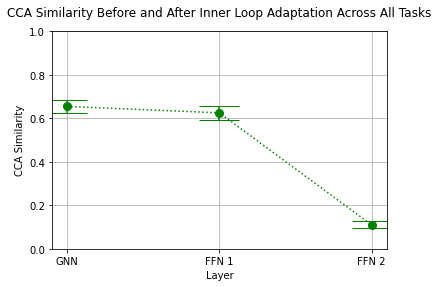

In [28]:
# ALL TASKS
gnn_mean_sim, gnn_std_sim, gnn_ci_interval = compute_cca_similarity_mean_std(tasks, sims['gnn'])
ffn_one_mean_sim, ffn_one_std_sim, fnn_one_ci_interval = compute_cca_similarity_mean_std(tasks, sims['ffn_1'])
ffn_two_mean_sim, ffn_two_std_sim, fnn_two_ci_interval = compute_cca_similarity_mean_std(tasks, sims['ffn_2'])
print('GNN sim score: ', gnn_mean_sim, 'GNN CI interval magnitude: ', gnn_ci_interval)
print('FFN 1 sim score: ', ffn_one_mean_sim, 'FFN 1 CI interval magnitude: ', fnn_one_ci_interval)
print('FFN 2 sim score: ',ffn_two_mean_sim, 'FFN 2 CI interval magnitude: ', fnn_two_ci_interval)
plt.errorbar( ['GNN', 'FFN 1', 'FFN 2'], [gnn_mean_sim, ffn_one_mean_sim, ffn_two_mean_sim], yerr = [gnn_mean_sim - gnn_ci_interval[0], ffn_one_mean_sim - fnn_one_ci_interval[0], ffn_two_mean_sim - fnn_two_ci_interval[0]], fmt='o', color='green', markersize=8, capsize=20, linestyle='dotted')
plt.ylim([0, 1])
plt.ylabel('CCA Similarity')
plt.xlabel('Layer')
plt.grid()
plt.title('CCA Similarity Before and After Inner Loop Adaptation Across All Tasks', pad=15)

Number of datapoints (sim scores):  100
Number of datapoints (sim scores):  100
Number of datapoints (sim scores):  100
GNN sim score:  0.6878485303216703 GNN CI interval magnitude:  (0.6565172124630367, 0.7191798481803038)
FFN 1 sim score:  0.6677867715359175 FFN 1 CI interval magnitude:  (0.6347013803725284, 0.7008721626993065)
FFN 2 sim score:  0.11978085255115549 FFN 2 CI interval magnitude:  (0.10046400057378196, 0.13909770452852901)


Text(0.5, 1.0, 'CCA Similarity Before and After Inner Loop Adaptation Across In-Distribution Tasks')

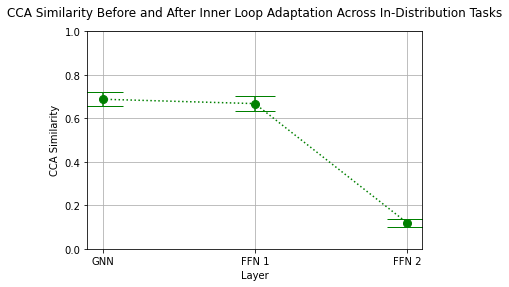

In [27]:
# IN DIST TASKS
gnn_mean_sim, gnn_std_sim, gnn_ci_interval = compute_cca_similarity_mean_std(IN_DIST, sims['gnn'])
ffn_one_mean_sim, ffn_one_std_sim, fnn_one_ci_interval = compute_cca_similarity_mean_std(IN_DIST, sims['ffn_1'])
ffn_two_mean_sim, ffn_two_std_sim, fnn_two_ci_interval = compute_cca_similarity_mean_std(IN_DIST, sims['ffn_2'])
print('GNN sim score: ', gnn_mean_sim, 'GNN CI interval magnitude: ', gnn_ci_interval)
print('FFN 1 sim score: ', ffn_one_mean_sim, 'FFN 1 CI interval magnitude: ', fnn_one_ci_interval)
print('FFN 2 sim score: ',ffn_two_mean_sim, 'FFN 2 CI interval magnitude: ', fnn_two_ci_interval)
plt.errorbar( ['GNN', 'FFN 1', 'FFN 2'], [gnn_mean_sim, ffn_one_mean_sim, ffn_two_mean_sim], yerr = [gnn_mean_sim - gnn_ci_interval[0], ffn_one_mean_sim - fnn_one_ci_interval[0], ffn_two_mean_sim - fnn_two_ci_interval[0]], fmt='o', color='green', markersize=8, capsize=20, linestyle='dotted')
plt.ylim([0, 1])
plt.ylabel('CCA Similarity')
plt.xlabel('Layer')
plt.grid()
plt.title('CCA Similarity Before and After Inner Loop Adaptation Across In-Distribution Tasks', pad=15)

Number of datapoints (sim scores):  30
Number of datapoints (sim scores):  30
Number of datapoints (sim scores):  30
GNN sim score:  0.544611131166503 GNN CI interval magnitude:  (0.48176411987015316, 0.6074581424628528)
FFN 1 sim score:  0.4835200731051788 FFN 1 CI interval magnitude:  (0.42749867681563763, 0.53954146939472)
FFN 2 sim score:  0.07759412025801837 FFN 2 CI interval magnitude:  (0.05746600797472416, 0.09772223254131258)


Text(0.5, 1.0, 'CCA Similarity Before and After Inner Loop Adaptation Across Out-of-Distribution Tasks')

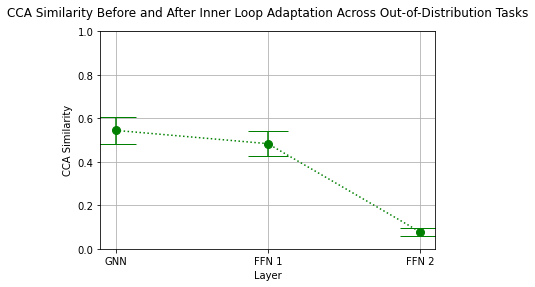

In [26]:
# OUT DIST TASKS
gnn_mean_sim, gnn_std_sim, gnn_ci_interval = compute_cca_similarity_mean_std(OUT_OF_DIST, sims['gnn'])
ffn_one_mean_sim, ffn_one_std_sim, fnn_one_ci_interval = compute_cca_similarity_mean_std(OUT_OF_DIST, sims['ffn_1'])
ffn_two_mean_sim, ffn_two_std_sim, fnn_two_ci_interval = compute_cca_similarity_mean_std(OUT_OF_DIST, sims['ffn_2'])
print('GNN sim score: ', gnn_mean_sim, 'GNN CI interval magnitude: ', gnn_ci_interval)
print('FFN 1 sim score: ', ffn_one_mean_sim, 'FFN 1 CI interval magnitude: ', fnn_one_ci_interval)
print('FFN 2 sim score: ',ffn_two_mean_sim, 'FFN 2 CI interval magnitude: ', fnn_two_ci_interval)
plt.errorbar( ['GNN', 'FFN 1', 'FFN 2'], [gnn_mean_sim, ffn_one_mean_sim, ffn_two_mean_sim], yerr = [gnn_mean_sim - gnn_ci_interval[0], ffn_one_mean_sim - fnn_one_ci_interval[0], ffn_two_mean_sim - fnn_two_ci_interval[0]], fmt='o', color='green', markersize=8, capsize=20, linestyle='dotted')
plt.ylim([0, 1])
plt.ylabel('CCA Similarity')
plt.xlabel('Layer')
plt.grid()
plt.title('CCA Similarity Before and After Inner Loop Adaptation Across Out-of-Distribution Tasks', pad=15)
plt.savefig('cca_sim_out_dist_tasks.pdf')

In [ ]:
# NOTES
# had to remove an assertion they had for preventing neurons > num datapoints
len(problematic_len_tasks) # tasks that have neurons > num datapoints 
# Took the mean CCA similiarity

# Q's 
# 1. What's a 'low' similarity? Seems a bit arbitrary